## Import, I/O and preprocessing 部分

In [1]:
!pip install /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl
!mkdir /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
!cp /kaggle/input/tabpfn-019-whl/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

Processing /kaggle/input/tabpfn-019-whl/tabpfn-0.1.9-py3-none-any.whl


首先，我们观察 `train.csv` 和 `greeks.csv` 的元素组成:

In [2]:
import numpy as np 
import pandas as pd 
import os
import xgboost
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import category_encoders as ce
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

from tabpfn import TabPFNClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import plot_tree
from xgboost import plot_importance

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE

'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
        
train_dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/train.csv")
meta_dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/greeks.csv")
sample_submission_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
test_dataset_df = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/test.csv")

print("\n训练集概貌如下:")
print(train_dataset_df.head())
print("\n完整训练集的尺寸是 {}。".format(train_dataset_df.shape))

print("\n训练集的元数据概貌如下:")
print(meta_dataset_df.head())
print("\n完整训练集元数据的尺寸是 {}。".format(meta_dataset_df.shape))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



训练集概貌如下:
             Id        AB          AF          AH         AM        AR  \
0  000ff2bfdfe9  0.209377  3109.03329   85.200147  22.394407  8.138688   
1  007255e47698  0.145282   978.76416   85.200147  36.968889  8.138688   
2  013f2bd269f5  0.470030  2635.10654   85.200147  32.360553  8.138688   
3  043ac50845d5  0.252107  3819.65177  120.201618  77.112203  8.138688   
4  044fb8a146ec  0.380297  3733.04844   85.200147  14.103738  8.138688   

         AX        AY         AZ          BC  ...        FL        FR  \
0  0.699861  0.025578   9.812214    5.555634  ...  7.298162   1.73855   
1  3.632190  0.025578  13.517790    1.229900  ...  0.173229   0.49706   
2  6.732840  0.025578  12.824570    1.229900  ...  7.709560   0.97556   
3  3.685344  0.025578  11.053708    1.229900  ...  6.122162   0.49706   
4  3.942255  0.054810   3.396778  102.151980  ...  8.153058  48.50134   

         FS         GB          GE            GF         GH         GI  \
0  0.094822  11.339138   72.6110

In [3]:
train_dataset_df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [4]:
train_dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

数据集：58 列，其中 1 列为 ID（没有用处），一列的病与否（0/1），feature 为 56。

不难发现两类数据比例严重不均衡。

<Axes: ylabel='Class'>

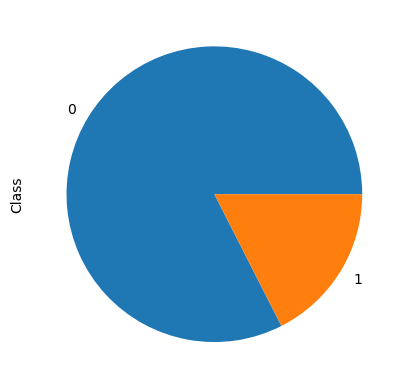

In [5]:
plot_df = train_dataset_df.Class.value_counts()
plot_df.plot(kind="pie")

In [6]:
'''
# 查看 float 数据的分布。先把他们搞到一个列表里。
NUM_FEATURE_COLUMNS = [i for i in train_dataset_df.columns if i not in ["Id", "EJ", "Class"]]

# 查看前六个。
figure, axis = plt.subplots(3, 2, figsize=(15, 15))
plt.subplots_adjust(hspace=0.25, wspace=0.3)

for i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):
    row = i//2
    col = i % 2
    bp = sns.barplot(ax=axis[row, col], x=train_dataset_df['Id'], y=train_dataset_df[column_name])
    bp.set(xticklabels=[])
    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)
    axis[row, col].set_title(column_name)
plt.show()
'''

'\n# 查看 float 数据的分布。先把他们搞到一个列表里。\nNUM_FEATURE_COLUMNS = [i for i in train_dataset_df.columns if i not in ["Id", "EJ", "Class"]]\n\n# 查看前六个。\nfigure, axis = plt.subplots(3, 2, figsize=(15, 15))\nplt.subplots_adjust(hspace=0.25, wspace=0.3)\n\nfor i, column_name in enumerate(NUM_FEATURE_COLUMNS[:6]):\n    row = i//2\n    col = i % 2\n    bp = sns.barplot(ax=axis[row, col], x=train_dataset_df[\'Id\'], y=train_dataset_df[column_name])\n    bp.set(xticklabels=[])\n    #bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 7)\n    axis[row, col].set_title(column_name)\nplt.show()\n'

---

可以看到这些特征里有许多样本的值是异常大的，假如使用平均法来处理缺省值，直觉上来说会发生较大误差。

**TODO**: 参考 [这里](https://zhuanlan.zhihu.com/p/576512900) 想个解决办法。

接下来，我们先简单装配一个简单的 NaN 处理。

In [7]:
column_names = list(train_dataset_df.columns.values)

# 看一看每个特征都有多少空出来的。
def check_nan(dataset: pd.DataFrame, column_names):
    for column in column_names:
        if dataset[column].isnull().sum() != 0:
            print("column: {0} --> {1}".format(column, dataset[column].isnull().sum()))
        
check_nan(train_dataset_df, column_names)

column: BQ --> 60
column: CB --> 2
column: CC --> 3
column: DU --> 1
column: EL --> 60
column: FC --> 1
column: FL --> 1
column: FS --> 2
column: GL --> 1


In [8]:
# 这个函数能这么写，本质上还是因为 EJ 列没有缺省值。
def fill_nan(dataset: pd.DataFrame, column_names):
    new_dataset = copy.deepcopy(dataset)
    
    for column in column_names:
        if dataset[column].isnull().sum() != 0:
            mean = dataset[column].mean()
            new_dataset[column].fillna(mean, inplace = True)
            
    return new_dataset
            
train_dataset_nonan = fill_nan(train_dataset_df, column_names)
train_dataset_nonan.isnull().values.any() # False

False

In [9]:
first_category = train_dataset_df.EJ.unique()[0] # first_category = 'B'

# 这里先不用带缺省值的，后面看情况。
# 把类别列换成 int 列，本来是想用 one-hot 编码的，但是参考了别的解决方案，没有使用，遂不用。
train_dataset_df.EJ = train_dataset_df.EJ.eq(first_category).astype('int') # True = 1, False = 0

# counter_1 = Counter(dataset_df.EJ) 509 108
# print(counter)

'''
# 生成新的训练数据集，保证两类数量相同。
# 正类（有病）比负类少，因此需要防止数据不平衡问题。
def bal_resample(df: pd.DataFrame):
    
    neg, pos = np.bincount(df['Class']) # 0:509 1:108

    one_df = df.loc[df['Class'] == 1] 
    zero_df = df.loc[df['Class'] == 0]
    zero_df = zero_df.sample(n=pos)
    undersampled_df = pd.concat([zero_df, one_df])
    
    return undersampled_df.sample(frac = 1)

bal_train_dataset = bal_resample(train_dataset_df)

print(bal_train_dataset.shape)
'''

"\n# 生成新的训练数据集，保证两类数量相同。\n# 正类（有病）比负类少，因此需要防止数据不平衡问题。\ndef bal_resample(df: pd.DataFrame):\n    \n    neg, pos = np.bincount(df['Class']) # 0:509 1:108\n\n    one_df = df.loc[df['Class'] == 1] \n    zero_df = df.loc[df['Class'] == 0]\n    zero_df = zero_df.sample(n=pos)\n    undersampled_df = pd.concat([zero_df, one_df])\n    \n    return undersampled_df.sample(frac = 1)\n\nbal_train_dataset = bal_resample(train_dataset_df)\n\nprint(bal_train_dataset.shape)\n"

我们切分 features 和 label。

In [10]:
predictor_columns = [n for n in train_dataset_df.columns if n != 'Class' and n != 'Id']

再自己生成一个 cross-entropy 函数。参考 [这里](https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/422442)。

In [11]:
def balanced_log_loss(y_true: np.ndarray, y_pred: np.ndarray):
    
    # y_true: 正确的标签，一个数组。
    # y_pred: 预测的概率数组，每一个值代表该位置有多大可能为有病（1），即 p_1。

    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    
    # 权重计算。
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    
    # 将数组 y_pred 中的元素限制在一个接近 0 和 1 的范围内，避免概率值太极端导致计算问题。
    # 在机器学习中，通常会对概率进行截断处理，以确保数值的稳定性和避免数值计算的错误。
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    
    # 交叉熵损失。
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    
    # 加权计算损失。
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    
    # 返回平均损失。
    return balanced_log_loss/(N_0+N_1)

## 模型训练部分

首先，设置一个内外层交叉验证模型。
- 外层交叉验证用于将数据集分成 10 个折，每次选取一个折作为验证集，剩下的 9 个折作为训练集，进行模型训练和评估；
- 内层交叉验证用于在每个外层验证集上进行 5 折交叉验证，即将当前验证集再划分为 5 折，用于选择最佳的模型超参数。

注：参考的代码没有使用 `cross_val_out` 这一项。

In [12]:
# cross_val_out = KFold(n_splits = 10, shuffle=True, random_state=42)
splits = 5
cross_val_in = KFold(n_splits = splits, shuffle=True, random_state=42)

In [13]:
class Ensemble():
    def __init__(self):
        
        # 缺省值填充。
        self.imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        
        # 分类器列表。这里也是个调参大头。
        self.classifiers = [xgboost.XGBClassifier(tree_method='gpu_hist', n_estimators=100,max_depth=3,learning_rate=0.15,subsample=0.9,colsample_bytree=0.85),
                          
                           # xgboost.XGBClassifier(tree_method='gpu_hist'),
                            
                           TabPFNClassifier(device='cuda', N_ensemble_configurations=48),
                          
                           TabPFNClassifier(device='cuda', N_ensemble_configurations=128),
                            
                           RandomForestClassifier(criterion='gini', max_depth= None, min_samples_leaf= 1, min_samples_split= 4,n_estimators= 200)
                           ]
        
    
    def fit(self,X,y):
        y = y.values
        unique_classes, y = np.unique(y, return_inverse=True)
        self.classes_ = unique_classes
        first_category = X.EJ.unique()[0]
        X.EJ = X.EJ.eq(first_category).astype('int')
        X = self.imputer.fit_transform(X)
        # X = normalize(X,axis=0)
        for classifier in self.classifiers:
            if classifier==self.classifiers[1] or classifier==self.classifiers[2]:
                classifier.fit(X,y,overwrite_warning =True)
            else :
                classifier.fit(X, y)
     
    def predict_proba(self, x):
        x = self.imputer.transform(x)
        # x = normalize(x,axis=0)
        probabilities = np.stack([classifier.predict_proba(x) for classifier in self.classifiers])
        averaged_probabilities = np.mean(probabilities, axis=0)
        class_0_est_instances = averaged_probabilities[:, 0].sum()
        others_est_instances = averaged_probabilities[:, 1:].sum()
        # Weighted probabilities based on class imbalance
        new_probabilities = averaged_probabilities * np.array([[1/(class_0_est_instances if i==0 else others_est_instances) for i in range(averaged_probabilities.shape[1])]])
        return new_probabilities / np.sum(new_probabilities, axis=1, keepdims=1) 

In [14]:
def training(model, x, y, y_meta, splits):
    outer_results = list()
    outer_accuracy = list()
    best_loss = np.inf
    split = 0
    models=[]
    for train_idx,val_idx in tqdm(cross_val_in.split(x), total = splits):
        split+=1
        x_train, x_val = x.iloc[train_idx],x.iloc[val_idx]
        y_train, y_val = y_meta.iloc[train_idx], y.iloc[val_idx]
        #model = Ensemble()        
        model.fit(x_train, y_train)
        models.append(model)
        y_pred = model.predict_proba(x_val)
        probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
        p0 = probabilities[:,:1]
        p0[p0 > 0.86] = 1
        p0[p0 < 0.14] = 0
        y_p = np.empty((y_pred.shape[0],))
        for i in range(y_pred.shape[0]):
            if p0[i]>=0.5:
                y_p[i]= False
            else :
                y_p[i]=True
        y_p = y_p.astype(int)
        loss = balanced_log_loss(y_val,y_p)
        diff_count = np.count_nonzero(y_val != y_p)
        accuracy = (y_p.size - diff_count) / y_p.size

        if loss<best_loss:
            best_model = model
            best_loss = loss
            best_accuracy = accuracy
            print('best_model_saved')
        
        outer_results.append(loss)
        outer_accuracy.append(accuracy)
        
        print('>val_loss=%.5f, split = %.1f' % (loss,split))
        print('accuracy=', str(accuracy))
    print('LOSS: %.5f' % (np.mean(outer_results)))
    print('ACCURACY: %.5f' % (np.mean(outer_accuracy)))
    return best_model, models

In [15]:
test_dataset_df.EJ = test_dataset_df.EJ.eq(first_category).astype('int') # True = 1, False = 0
test_predictors = test_dataset_df[predictor_columns] # 去掉 id。

In [16]:
ros = BorderlineSMOTE(random_state=42)

train_dataset_nonan = fill_nan(train_dataset_df, column_names)
train_dataset_nonan = train_dataset_nonan.drop(['Id'],axis=1)


# train_ros，有 ID，EJ(int)， Class。
train_ros, y_ros = ros.fit_resample(train_dataset_nonan, meta_dataset_df.Alpha)

print('Original dataset shape')
print(meta_dataset_df.Alpha.value_counts())
print('Resample dataset shape')
print( y_ros.value_counts())

Original dataset shape
A    509
B     61
G     29
D     18
Name: Alpha, dtype: int64
Resample dataset shape
B    509
A    509
D    509
G    509
Name: Alpha, dtype: int64


In [17]:
# x_ros = train_ros.drop(['Class', 'Id'],axis=1)
x_ros = train_ros.drop(['Class'],axis=1)
y_ = train_ros.Class

In [18]:
yt = Ensemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [19]:
from tqdm.notebook import tqdm

m,models = training(yt, x_ros, y_, y_ros, splits)

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_24/4132808215.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


best_model_saved
>val_loss=0.00000, split = 1.0
accuracy= 1.0


/tmp/ipykernel_24/4132808215.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.18349, split = 2.0
accuracy= 0.9901719901719902


/tmp/ipykernel_24/4132808215.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.32402, split = 3.0
accuracy= 0.9828009828009828


/tmp/ipykernel_24/4132808215.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.18766, split = 4.0
accuracy= 0.9877149877149877


/tmp/ipykernel_24/4132808215.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.EJ = X.EJ.eq(first_category).astype('int')


>val_loss=0.21518, split = 5.0
accuracy= 0.9852579852579852
LOSS: 0.18207
ACCURACY: 0.98919


In [20]:
y_.value_counts()/y_.shape[0]

1    0.75
0    0.25
Name: Class, dtype: float64

In [21]:
y_pred = m.predict_proba(test_predictors)

In [22]:
#y_pred=np.mean(y_pred_list, axis=0)
probabilities = np.concatenate((y_pred[:,:1], np.sum(y_pred[:,1:], 1, keepdims=True)), axis=1)
p0 = probabilities[:,:1]
p0[p0 > 0.60] = 1
p0[p0 < 0.25] = 0

In [23]:
submission = pd.DataFrame(test_dataset_df["Id"], columns=["Id"])
submission["class_0"] = p0
submission["class_1"] = 1 - p0
submission.to_csv('submission.csv', index=False)

In [24]:
submission_df = pd.read_csv('submission.csv')
submission_df

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5
